

```
Machine Learning to predict the cost of the path travelled by Lunokhod

Library: Keras, Sklearn
```














In [92]:
# importing requried libraries:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers

import sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [58]:
# Loading the custom data made using RAND () in excel and assigning ID's to the paths 

df_test = pd.read_csv("/content/test.csv")
df_train = pd.read_csv("/content/train.csv")
df = pd.merge(df_train, df_test, how="outer")

df.head()

print(df.shape)

(1000, 2)


/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


Let us consider the `cost` to be our `Y` and followed by `Number of Nodes` and `ID's` to be `X`, as we are following random data genration technique we can consider that we followed a `dijkstra's algorithm` to get the costs for the following `set of nodes` and `paths`. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


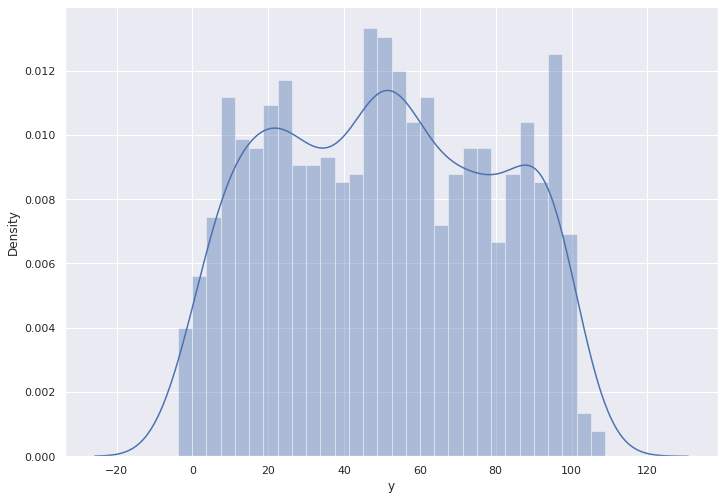

In [85]:
# checking if there are any outliners for the complete datasets' Y (Costs)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['y'], bins=30)
plt.show()

We `can't see any outliners` hence we can carryon to build the multiple linear regression model for the custom made dataset

In [75]:
df.isna().sum()

x    0
y    1
dtype: int64

In [78]:
df = df.dropna()

In [79]:
df.isna().sum()

x    0
y    0
dtype: int64

In [109]:
'''
Common splits are:
Train: 80%, Test: 20%
Train: 67%, Test: 33%

'''

# For the sample of 1000, I have considered a split of 4:1 (train:test)
train, test = train_test_split(df, test_size = 0.2)

In [110]:
train.shape

(799, 2)

In [111]:
test.shape

(200, 2)

**Now let us present the data using matplotlib/seaborn**

* *`scatter plot`*
* *`line graph`*

Text(0, 0.5, 'Cost of Path')

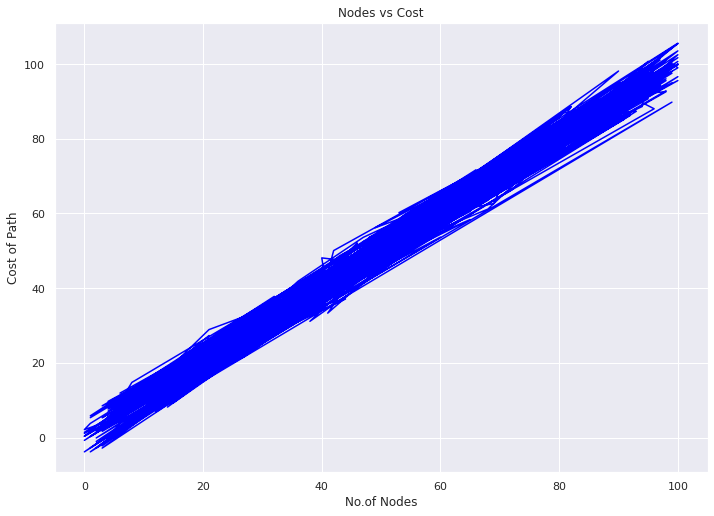

In [112]:
# Scatter plot 
x = train['x']
y = train['y']

plt.plot(x, y, color = 'blue')
plt.title("Nodes vs Cost")
plt.xlabel('No.of Nodes')
plt.ylabel('Cost of Path')

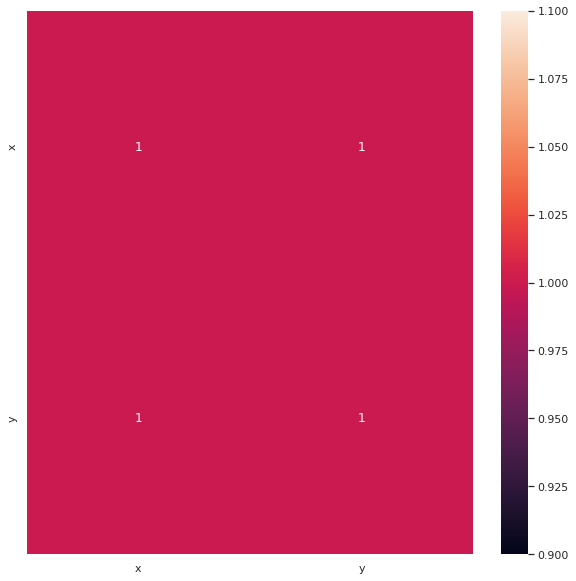

In [199]:
#observing correlation using heatmap for the train dataset
plt.figure(figsize=(10,10))
correlation_matrix =train.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [200]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,799.0,50.598248,28.982192,0.000000,25.000000,50.000000,75.000000,100.000000
y,799.0,50.707961,29.135698,-3.839981,25.398081,50.592199,75.109755,105.591837


In [201]:
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('y')
test_labels = test_features.pop('y')

In [202]:
train.describe().transpose()[['mean', 'std']]

,mean,std
x,50.598248,28.982192
y,50.707961,29.135698


In [203]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [204]:
normalizer.adapt(np.array(train_features))

In [205]:
print(normalizer.mean.numpy())

[[50.59824]]


In [206]:
#When the layer is called, it returns the input data, with each feature independently normalized:

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[33.]]

Normalized: [[-0.61]]


In [207]:
cost = np.array(train_features['x'])

cost_normalizer = layers.Normalization(input_shape=[1,], axis=None)
cost_normalizer.adapt(cost)

In [217]:
cost_model = tf.keras.Sequential([
    cost_normalizer,
    layers.Dense(units=1)
])

cost_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_26 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [218]:
cost_model.predict(cost[:10])

array([[-0.45080775],
       [ 1.1374239 ],
       [-0.19464137],
       [ 0.18960822],
       [ 0.80440754],
       [-0.96314055],
       [ 0.13837492],
       [-1.1168404 ],
       [-0.04094153],
       [ 0.34330806]], dtype=float32)

In [220]:
cost_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.3),
    loss='mean_absolute_error')

In [221]:
%%time
history = cost_model.fit(
    train_features['x'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 7.03 s, sys: 352 ms, total: 7.38 s
Wall time: 7.49 s


In [222]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.264028,2.255705,95
96,2.265072,2.248662,96
97,2.263540,2.235945,97
98,2.268460,2.270018,98
99,2.286767,2.234375,99


In [223]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [y]')
  plt.legend()
  plt.grid(True)

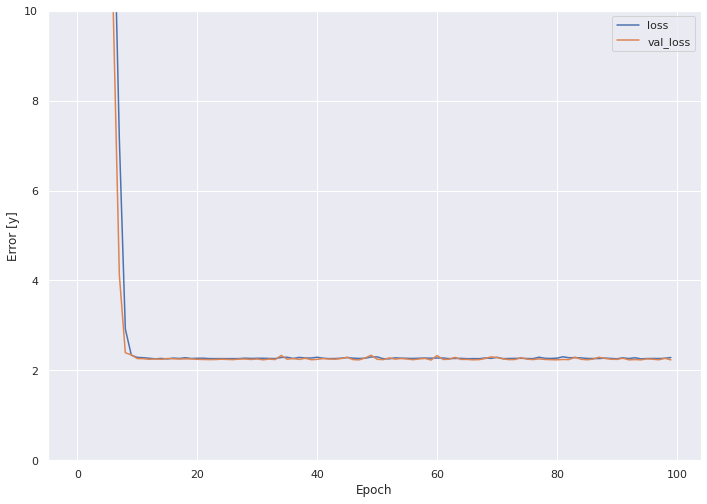

In [224]:
plot_loss(history)

In [225]:
test_results = {}

test_results['cost_model'] = cost_model.evaluate(
    test_features['x'],
    test_labels, verbose=0)

In [227]:
x = tf.linspace(0.0, 250, 251)
y = cost_model.predict(x)

In [228]:
def plot_costofPath(x, y):
  plt.scatter(train_features['x'], train_labels, label='Data')
  plt.plot(x, y, color='red', label='Predictions')
  plt.xlabel('x: Number of Nodes')
  plt.ylabel('y: Path Cost')
  plt.legend()

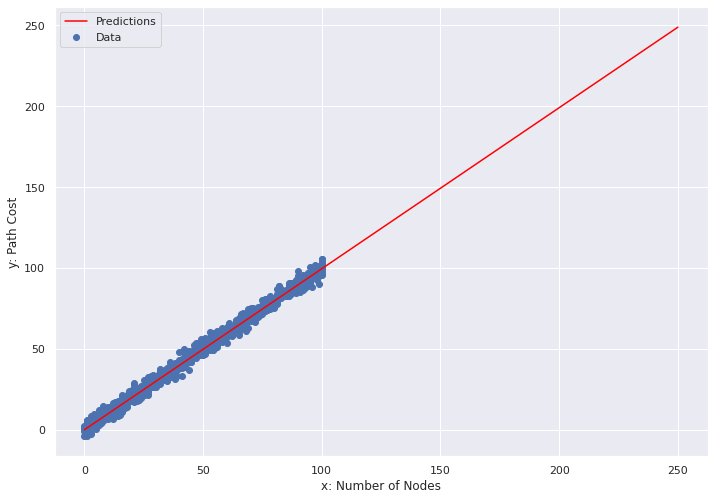

In [229]:
plot_costofPath(x, y)